In [1]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
import matplotlib.pyplot as plt

C:\Users\Shaurya\anaconda3\envs\QiskitEnv\lib\site-packages\requests_ntlm\requests_ntlm.py:5: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  from cryptography import x509


In [2]:
sim = Aer.get_backend('qasm_simulator')

In [43]:
nq = 2
m = 3
q = QuantumRegister(nq,'q')
c = ClassicalRegister(m,'c')

qc_S = QuantumCircuit(q,c)
theta=0.25

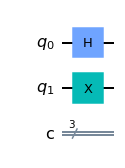

In [44]:
qc_S.h(0)
qc_S.x(1)
qc_S.draw('mpl')


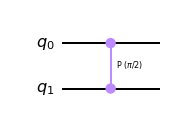

In [45]:
cu_circ = QuantumCircuit(2)
cu_circ.cp(2*np.pi*theta,0,1)
cu_circ.draw('mpl')


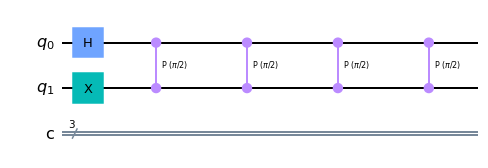

In [46]:
for _ in range(2**(m-1)):
    qc_S.cp(2*np.pi*theta,0,1)
qc_S.draw('mpl')


In [47]:
def x_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    qc.h(qubit)
    qc.measure(qubit, cbit)


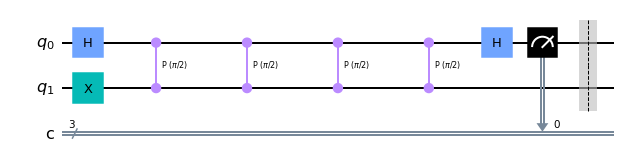

In [48]:
x_measurement(qc_S, q[0], c[0])
qc_S.barrier()
qc_S.draw('mpl')


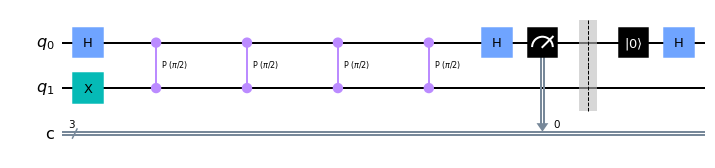

In [49]:
qc_S.reset(0)
qc_S.h(0)
qc_S.draw('mpl')


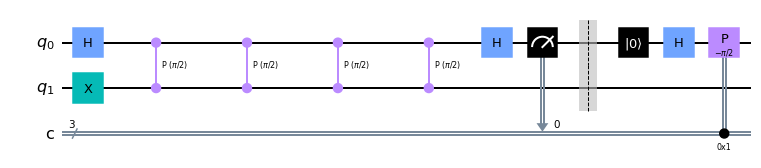

In [50]:
qc_S.p(-np.pi/2,0).c_if(c,1)
qc_S.draw('mpl') 


In [51]:
## 2^t c-U operations (with t=m-2)
for _ in range(2**(m-2)):
    qc_S.cp(2*np.pi*theta,0,1)

x_measurement(qc_S, q[0], c[1])
qc_S.barrier()


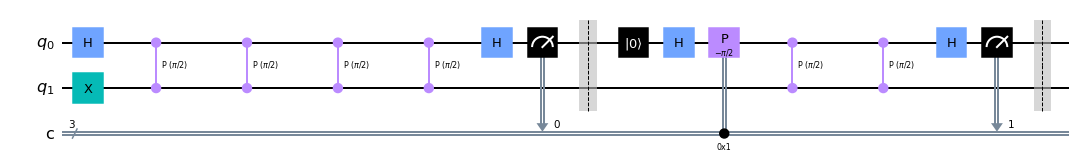

In [52]:
qc_S.draw('mpl')


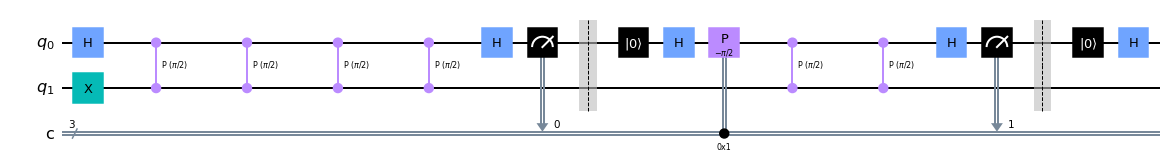

In [53]:
qc_S.reset(0)
qc_S.h(0)
qc_S.draw('mpl')


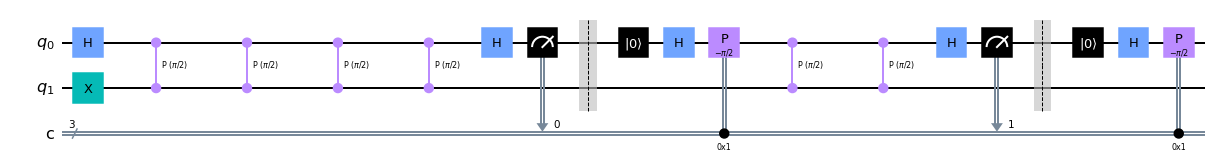

In [54]:
qc_S.p(-np.pi/2,0).c_if(c,1)
qc_S.draw('mpl') 


In [55]:
for _ in range(2**(m-2)):
    qc_S.cp(2*np.pi*theta,0,1)

x_measurement(qc_S, q[0], c[1])


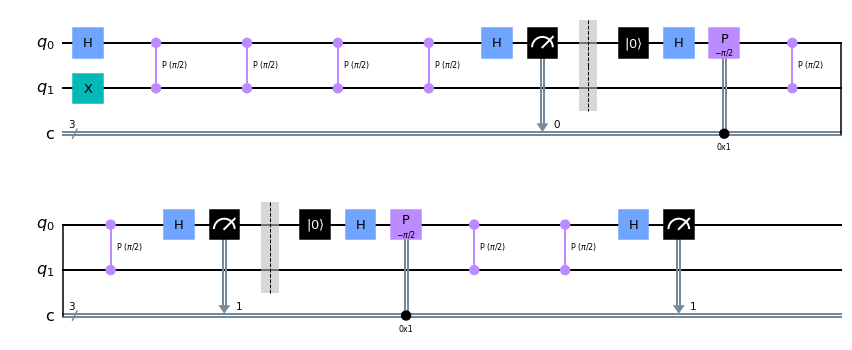

In [77]:
qc_S.draw('mpl',fold=17,scale=1)


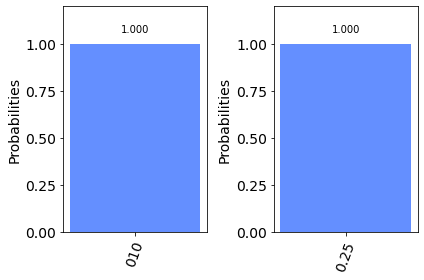

In [42]:
sim = Aer.get_backend('qasm_simulator')
count0 = sim.run(transpile(qc_S, sim)).result().get_counts()

key_new = [str(int(key,2)/2**m) for key in list(count0.keys())]
count1 = dict(zip(key_new, count0.values()))

fig, ax = plt.subplots(1,2)
plot_histogram(count0, ax=ax[0])
plot_histogram(count1, ax=ax[1])
plt.tight_layout()


In [385]:
# Vary thermal noise parameters
accuracy_values = []
thermal_values = np.linspace(0, 1, 11)  # Vary thermal noise from 0 to 1

for thermal_value in thermal_values:
    # Update thermal relaxation errors with varying parameters
    errors_reset = thermal_relaxation_error(T1s[0], T2s[0], time_reset, thermal_value)
    errors_measure = thermal_relaxation_error(T1s[0], T2s[0], time_measure, thermal_value)
    errors_u1  = thermal_relaxation_error(T1s[0], T2s[0], time_u1, thermal_value)
    errors_u2  = thermal_relaxation_error(T1s[0], T2s[0], time_u2, thermal_value)
    errors_u3  = thermal_relaxation_error(T1s[0], T2s[0], time_u3, thermal_value)
    errors_cx = thermal_relaxation_error(T1s[0], T2s[0], time_cx, thermal_value)

    # Clear and recreate the noise model
    noise_thermal = NoiseModel()
    noise_thermal.add_quantum_error(errors_reset, "reset", [0])
    noise_thermal.add_quantum_error(errors_measure, "measure", [0])
    noise_thermal.add_quantum_error(errors_u1, "u1", [0])
    noise_thermal.add_quantum_error(errors_u2, "u2", [0])
    noise_thermal.add_quantum_error(errors_u3, "u3", [0])
    noise_thermal.add_quantum_error(errors_cx, "cx", [(0, 1)])

    # Clear and recreate the simulator with the updated noise model
    sim_thermal = AerSimulator(noise_model=noise_thermal)
    circ_tthermal = transpile(qc_S, sim_thermal)

    # Run and get counts
    result_thermal = sim_thermal.run(circ_tthermal).result()
    counts_thermal = result_thermal.get_counts(0)

    # Calculate accuracy
    accuracy = counts_thermal.get('0', 0) / sum(counts_thermal.values())
    accuracy_values.append(accuracy)

# Plot accuracy vs thermal noise
plt.plot(thermal_values, accuracy_values, marker='o')
plt.xlabel('Thermal Noise')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Thermal Noise')
plt.show()


NoiseError: '1 qubit QuantumError cannot be applied to 2 qubit instruction "cx".'

In [379]:
count=[]
50,30
130,100
120,80
110,70
100,60
80,20
50,10
40,5

(130, 100)

In [519]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(40e2, 5e2, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['u2', 'measure', 'u3', 'cx', 'reset']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


In [515]:
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error


# Thermal noisy simulation
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(48e2, 10e2, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])


In [520]:
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error


# t1 =50e3 # Sampled from normal distribution mean 50 microsec
# t2 = 70e3  # Sampled from normal distribution mean 50 microsec
# time=100
# noise_thermal=thermal_relaxation_error(t1, t2, time, excited_state_population=0)

In [521]:
sim_thermal = AerSimulator(noise_model=noise_thermal)

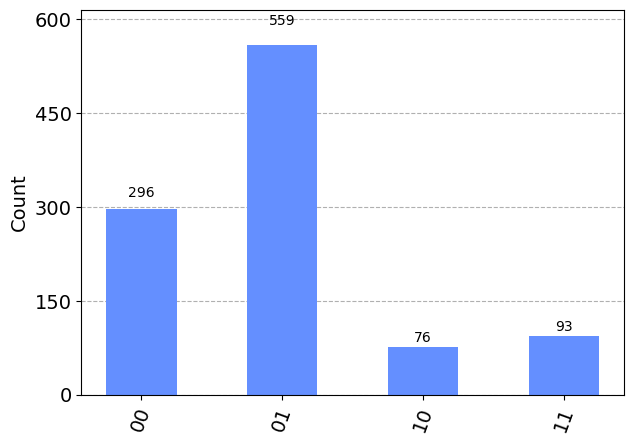

In [524]:
circ_tthermal = transpile(qc_S, sim_thermal)
# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)


[]

In [525]:
max_state = max(counts_thermal, key=counts_thermal.get)
max_count = counts_thermal[max_state]
count.append(max_count)
count

[972, 914, 838, 788, 735, 691, 584, 559]

In [575]:
x=[[150,130],
[130,100],
[120,80],
[110,70],
[100,60],
[80,20],
[50,10],
[40,5]]
# y=count.copy()

In [576]:
y

[972, 914, 838, 788, 735, 691, 584, 559]

In [577]:
x,y

np.mean(x[0])

140.0

In [591]:
import matplotlib.pyplot as plt
import numpy as np
x1=[]
for i in range(len(x)): 
    x1.append(np.mean(x[i]))
print(x1)

[140.0, 115.0, 100.0, 90.0, 80.0, 50.0, 30.0, 22.5]


In [594]:
y2=[943, 924, 717, 734, 717, 580, 475, 451]
print(y,y2)
y2.reverse()

[559, 584, 691, 735, 788, 838, 914, 972] [943, 924, 717, 734, 717, 580, 475, 451]


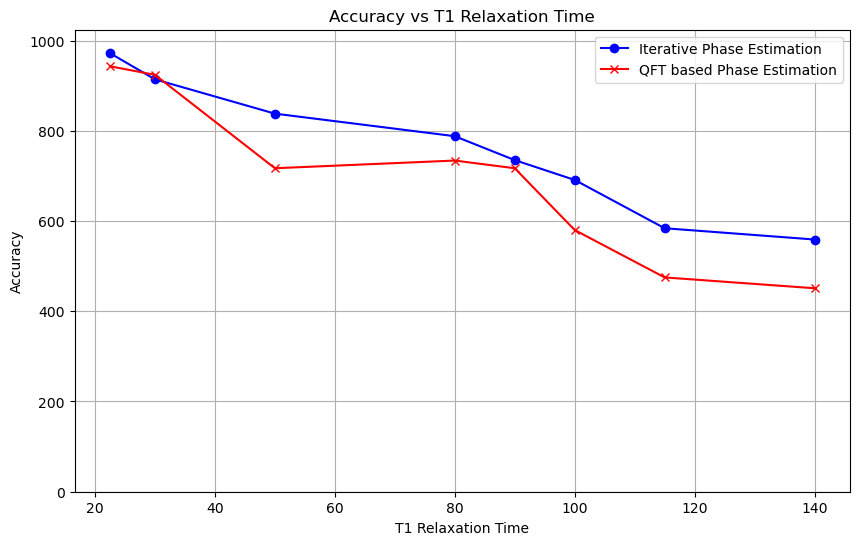

In [596]:
# x1.reverse()
# y.reverse()
# y2.reverse()
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x1, y, marker='o', linestyle='-', color='b', label='Iterative Phase Estimation')
plt.plot(x1, y2, marker='x', linestyle='-', color='r', label='QFT based Phase Estimation')

plt.title('Accuracy vs T1 Relaxation Time')
plt.xlabel('T1 Relaxation Time')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 1024)  # Set y-axis limits to cover the range from 0 to 1024
plt.show()

In [130]:
# Example error probabilities


In [581]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram


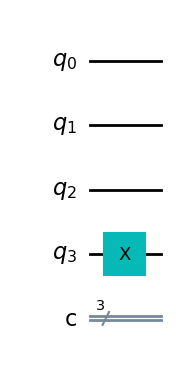

In [582]:
qpe = QuantumCircuit(4, 3)
qpe.x(3)
qpe.draw('mpl')


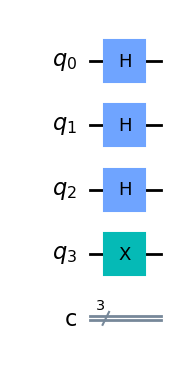

In [532]:
for qubit in range(3):
    qpe.h(qubit)
qpe.draw('mpl')


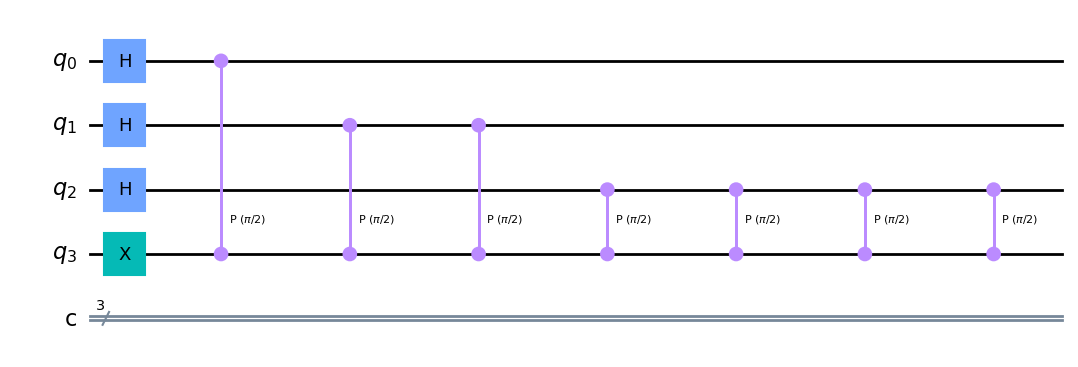

In [533]:
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(math.pi/2, counting_qubit, 3); # This is CU
    repetitions *= 2
qpe.draw('mpl')


In [534]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)


In [535]:
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, 3)
# Measure
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)


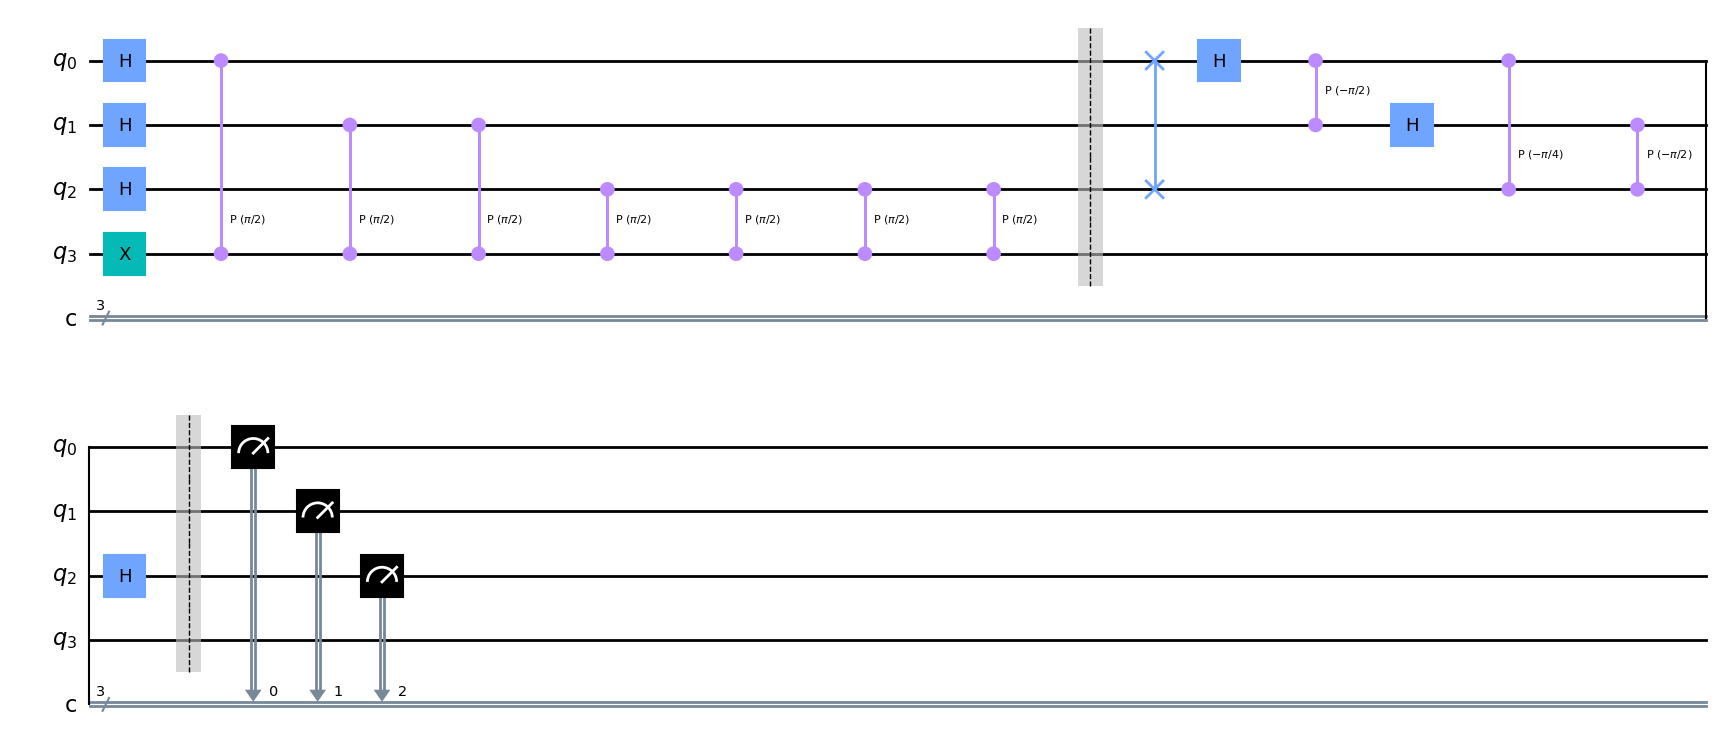

In [536]:
qpe.draw('mpl')

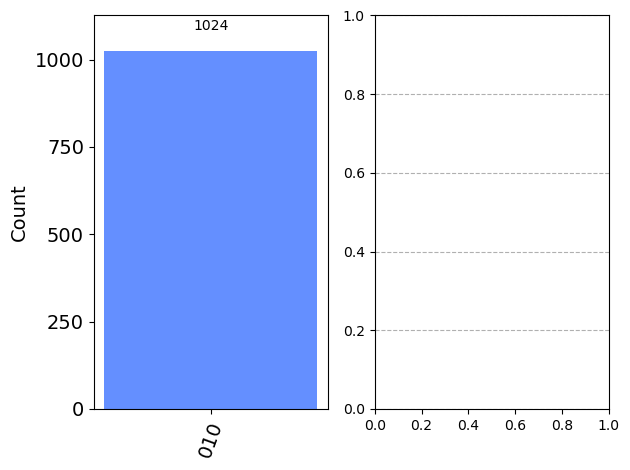

In [537]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024

count0 = sim.run(transpile(qpe, aer_sim)).result().get_counts()

key_new = [str(int(key,2)/2**m) for key in list(count0.keys())]
count1 = dict(zip(key_new, count0.values()))

fig, ax = plt.subplots(1,2)
plot_histogram(count0, ax=ax[0])
plt.tight_layout()


In [ ]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(40e2, 5e2, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)


In [226]:
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error




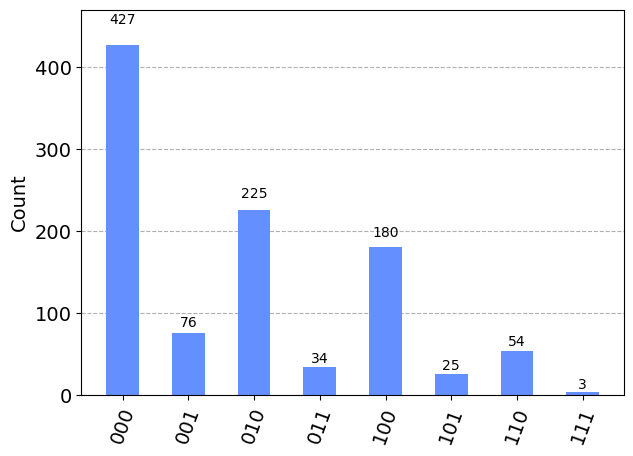

In [227]:
circ_tthermal = transpile(qpe, sim_thermal)

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)
